<a href="https://colab.research.google.com/github/SANJAYKUMAR0706/Citypulse_Fine-grained-change-detection/blob/main/citypulse_sanjay_final1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
from itertools import combinations

# Path to downloaded GSV images
root = '/content/drive/MyDrive/CityPulse/images'
output_csv = '/content/drive/MyDrive/CityPulse/image_pairs_all_combinations.csv'

pairs = []

# Loop through each city and location
for city in sorted(os.listdir(root)):
    city_path = os.path.join(root, city)
    if not os.path.isdir(city_path):
        continue

    for location in sorted(os.listdir(city_path)):
        location_path = os.path.join(city_path, location)
        if not os.path.isdir(location_path):
            continue

        # Get all image filenames in sorted (chronological) order
        images = sorted([f for f in os.listdir(location_path) if f.endswith('.jpg')])

        # Skip locations with < 2 images (can't pair)
        if len(images) < 2:
            continue

        # Generate all possible image pairs (in order)
        for img1, img2 in combinations(images, 2):
            img1_path = os.path.join(location_path, img1)
            img2_path = os.path.join(location_path, img2)
            pairs.append([img1_path, img2_path])

# Convert to DataFrame
df = pd.DataFrame(pairs, columns=['image_1', 'image_2'])

# Save to CSV
df.to_csv(output_csv, index=False)
print(f" Total pairs generated: {len(df)}")
print(f"📄 Saved to: {output_csv}")

In [ ]:
import os
import pandas as pd
from IPython.display import display, Image, clear_output
import ipywidgets as widgets

#  Paths
input_csv = '/content/drive/MyDrive/citypulse-final/image_pairs_all_combinations.csv'
output_csv = '/content/drive/MyDrive/citypulse-final/pairwise_training_data2.csv'

# Load existing labels (if any)
if os.path.exists(output_csv):
    labeled_df = pd.read_csv(output_csv)
    labeled_set = set(zip(labeled_df['image_1'], labeled_df['image_2']))
    print(f"🔁 Resuming... Already labeled: {len(labeled_set)} pairs.")
else:
    labeled_df = pd.DataFrame(columns=['image_1', 'image_2', 'label'])
    labeled_set = set()
    print("🆕 Starting fresh labeling session.")

# Load all image pairs
df_all = pd.read_csv(input_csv)
total_pairs = len(df_all)

# Index to track progress
start_idx = 0
for i, row in enumerate(df_all.itertuples(index=False)):
    if (row.image_1, row.image_2) not in labeled_set:
        start_idx = i
        break

# Interactive labeling function
def label_pair(index):
    row = df_all.iloc[index]
    img1, img2 = row['image_1'], row['image_2']

    clear_output(wait=True)
    print(f"🔹 Pair {index + 1}/{total_pairs}")
    print(f"📍 {img1.split('/')[-3:]}")
    print(f"📍 {img2.split('/')[-3:]}")

    display(Image(filename=img1, width=400))
    display(Image(filename=img2, width=400))

    label_widget = widgets.ToggleButtons(
        options=[('No Change', 0), ('Change', 1)],
        description='Label:',
        button_style='info'
    )

    submit_button = widgets.Button(description="Submit Label", button_style='success')

    output_box = widgets.Output()

    def on_submit(b):
        label_value = label_widget.value
        new_row = pd.DataFrame([[img1, img2, label_value]], columns=['image_1', 'image_2', 'label'])
        new_row.to_csv(output_csv, mode='a', header=not os.path.exists(output_csv), index=False)
        with output_box:
            clear_output()
            print(f"✅ Saved label: {label_value} | Proceeding to next pair...")
        next_index = index + 1
        if next_index < total_pairs:
            label_pair(next_index)
        else:
            print(" All pairs labeled!")

    submit_button.on_click(on_submit)

    display(widgets.VBox([label_widget, submit_button, output_box]))

# Start labeling
label_pair(start_idx)


🧮 Label distribution:
label
0    613
1    547
Name: count, dtype: int64


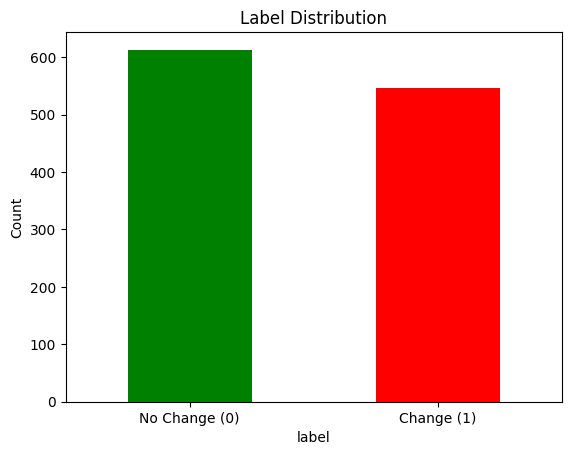

In [ ]:
import pandas as pd

# Load your labeled dataset
csv_path = '/content/drive/MyDrive/citypulse-final/pairwise_training_data2.csv'
df = pd.read_csv(csv_path)

# Count how many 0s and 1s in the label column
label_counts = df['label'].value_counts()

print("🧮 Label distribution:")
print(label_counts)

# Optional: Show as a bar chart
import matplotlib.pyplot as plt

label_counts.plot(kind='bar', color=['green', 'red'])
plt.xticks(ticks=[0, 1], labels=['No Change (0)', 'Change (1)'], rotation=0)
plt.title('Label Distribution')
plt.ylabel('Count')
plt.show()

In [ ]:
# 📒 CityPulse - Urban Change Detection
# --------------------------------------------------
# This notebook trains a Siamese network on labeled Google Street View (GSV) image pairs
# using DINOv2 as the image encoder. Dataset: pairwise_training_data2.csv

#  STEP 1: Install Dependencies
!pip install -q timm torch torchvision pandas scikit-learn

#  STEP 2: Import Libraries
import os
import torch
import timm
import pandas as pd
import numpy as np
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

#  STEP 3: Define Preprocessing (DINOv2-style)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#  STEP 4: Define Custom Dataset
class SiameseImagePairDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img1 = Image.open(row['image_1']).convert("RGB")
        img2 = Image.open(row['image_2']).convert("RGB")
        label = torch.tensor(row['label'], dtype=torch.float)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label

#  STEP 5: Define DINOv2 Encoder Wrapper (FIXED)
class DinoEncoder(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        # FIX: extract the CLS token from the DINOv2 feature dict
        return self.model.forward_features(x)["x_norm_clstoken"]

#  STEP 6: Define Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Sequential(
            nn.Linear(768 * 2, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        with torch.no_grad():  # Encoder is frozen
            f1 = self.encoder(x1)
            f2 = self.encoder(x2)
        concat = torch.cat((f1, f2), dim=1)
        return self.fc(concat).squeeze()

#  STEP 7: Load CSV and Split Dataset
csv_path = "/content/drive/MyDrive/citypulse-final/pairwise_training_data2.csv"
data = pd.read_csv(csv_path)
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)

#  STEP 8: Create DataLoaders
train_dataset = SiameseImagePairDataset("train.csv", transform)
test_dataset = SiameseImagePairDataset("test.csv", transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

#  STEP 9: Load Pretrained DINOv2
encoder = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14', source='github')
dino_encoder = DinoEncoder(encoder)

#  STEP 10: Train Siamese Model with Checkpointing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork(dino_encoder).to(device)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)
loss_fn = nn.BCELoss()

#  Resume from checkpoint if available
checkpoint_path = "citypulse_siamese_checkpoint.pt"
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f" Resuming from epoch {start_epoch}")

print("\n Starting Training...")
num_epochs = 10
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0
    for img1, img2, labels in train_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        preds = model(img1, img2)
        loss = loss_fn(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {running_loss:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_path)
    print(f" Checkpoint saved for epoch {epoch+1}")

#  STEP 11: Evaluate
model.eval()
preds_all, labels_all = [], []
with torch.no_grad():
    for img1, img2, labels in test_loader:
        img1, img2 = img1.to(device), img2.to(device)
        preds = model(img1, img2)
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(labels.numpy())

# Threshold at 0.5 for binary classification
preds_bin = [1 if p > 0.5 else 0 for p in preds_all]
print("\n Evaluation Results:")
print("Accuracy:", accuracy_score(labels_all, preds_bin))
print("AUC Score:", roc_auc_score(labels_all, preds_all))


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main



🚀 Starting Training...
Epoch 1: Loss = 18.5260
💾 Checkpoint saved for epoch 1
Epoch 2: Loss = 14.3907
💾 Checkpoint saved for epoch 2
Epoch 3: Loss = 12.2174
💾 Checkpoint saved for epoch 3
Epoch 4: Loss = 10.6819
💾 Checkpoint saved for epoch 4
Epoch 5: Loss = 9.6874
💾 Checkpoint saved for epoch 5
Epoch 6: Loss = 8.6150
💾 Checkpoint saved for epoch 6
Epoch 7: Loss = 7.9982
💾 Checkpoint saved for epoch 7
Epoch 8: Loss = 7.2966
💾 Checkpoint saved for epoch 8
Epoch 9: Loss = 6.4930
💾 Checkpoint saved for epoch 9
Epoch 10: Loss = 6.5239
💾 Checkpoint saved for epoch 10

✅ Evaluation Results:
Accuracy: 0.8663793103448276
AUC Score: 0.9342880584769151


In [ ]:
!cp train.csv /content/drive/MyDrive/citypulse-final/train.csv
!cp test.csv /content/drive/MyDrive/citypulse-final/test.csv
print("✅ Saved train.csv and test.csv to your Drive.")
!cp citypulse_siamese_checkpoint.pt /content/drive/MyDrive/citypulse-final/
print("✅ Model saved to: /content/drive/MyDrive/citypulse-final/citypulse_siamese_checkpoint.pt")


✅ Model saved to: /content/drive/MyDrive/citypulse-final/citypulse_siamese_checkpoint.pt


| Metric       | Value    |
| ------------ | -------- |
| ✅ Accuracy   | `~86.6%` |
| 🎯 AUC Score | `~0.93`  |
Accuracy: The percentage of correct predictions (0 or 1) on the test set.

AUC (Area Under Curve): Measures how well the model separates the two classes.
Closer to 1.0 = better.

What we have Completed so far :( stage 1 of the work)

1 Downloaded Google Street View images

2 Generated all possible image pairs

3 Manually labeled 1,160 pairs (613 no change, 547 change)

4 Trained a Siamese model with DINOv2 features

5 Evaluated on unseen test data (232 pairs)

In [ ]:
#  Export predictions to CSV for manual inspection
output_csv = "/content/drive/MyDrive/citypulse-final/test_predictions.csv"

predictions = []

model.eval()
with torch.no_grad():
    for img1, img2, labels in test_loader:
        img1, img2 = img1.to(device), img2.to(device)
        scores = model(img1, img2).cpu().numpy()
        labels_np = labels.numpy()

        for i in range(len(scores)):
            predicted_label = 1 if scores[i] > 0.5 else 0
            predictions.append([
                test_dataset.data.iloc[len(predictions)]['image_1'],
                test_dataset.data.iloc[len(predictions)]['image_2'],
                int(labels_np[i]),
                float(scores[i]),
                predicted_label
            ])

# Save as CSV
df_preds = pd.DataFrame(predictions, columns=[
    "image_1", "image_2", "ground_truth", "predicted_score", "predicted_label"
])
df_preds.to_csv(output_csv, index=False)

print(f"✅ Predictions saved to: {output_csv}")


✅ Predictions saved to: /content/drive/MyDrive/citypulse-final/test_predictions.csv


In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# Load prediction CSV
preds_df = pd.read_csv("/content/drive/MyDrive/citypulse-final/test_predictions.csv")

# Create folders
base_dir = "/content/citypulse_examples"
os.makedirs(base_dir, exist_ok=True)

def save_image_pair(img1_path, img2_path, save_path, title):
    img1 = Image.open(img1_path).convert("RGB").resize((400, 300))
    img2 = Image.open(img2_path).convert("RGB").resize((400, 300))
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    axs[0].imshow(img1); axs[0].axis("off"); axs[0].set_title("Image 1")
    axs[1].imshow(img2); axs[1].axis("off"); axs[1].set_title("Image 2")
    fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Function to process and save a group
def process_group(df, group_name):
    folder = os.path.join(base_dir, group_name)
    os.makedirs(folder, exist_ok=True)
    for i, row in df.iterrows():
        save_path = os.path.join(folder, f"pair_{i+1}.png")
        title = f"GT: {row['ground_truth']} | Pred: {row['predicted_score']:.2f} → {row['predicted_label']}"
        save_image_pair(row['image_1'], row['image_2'], save_path, title)

# Define groups
confident_correct = preds_df[
    ((preds_df['predicted_score'] > 0.9) & (preds_df['ground_truth'] == 1)) |
    ((preds_df['predicted_score'] < 0.1) & (preds_df['ground_truth'] == 0))
].head(5)

wrong_preds = preds_df[preds_df['ground_truth'] != preds_df['predicted_label']].head(5)

unsure_preds = preds_df[
    (preds_df['predicted_score'] > 0.45) & (preds_df['predicted_score'] < 0.55)
].head(5)

# Save each group
process_group(confident_correct, "confident_correct")
process_group(wrong_preds, "wrong_predictions")
process_group(unsure_preds, "unsure_predictions")

print("✅ Saved prediction examples to:", base_dir)


✅ Saved prediction examples to: /content/citypulse_examples


In [ ]:
!cp -r /content/citypulse_examples /content/drive/MyDrive/citypulse-final/
print("✅ Visual prediction examples saved to your Drive at: /MyDrive/citypulse-final/citypulse_examples/")


✅ Visual prediction examples saved to your Drive at: /MyDrive/citypulse-final/citypulse_examples/


In [ ]:
import os
import torch
import pandas as pd
from PIL import Image
from torchvision import transforms
from itertools import combinations
from tqdm import tqdm
import matplotlib.pyplot as plt

# 📌 Paths
root_dir = "/content/drive/MyDrive/citypulse-final/images"
model_ckpt = "/content/drive/MyDrive/citypulse-final/citypulse_siamese_checkpoint.pt"
output_csv = "/content/drive/MyDrive/citypulse-final/change_scores_per_location.csv"
plot_dir = "/content/drive/MyDrive/citypulse-final/change_plots"
os.makedirs(plot_dir, exist_ok=True)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SAME NETWORK CLASSES USED IN STAGE 1
class DinoEncoder(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model.forward_features(x)["x_norm_clstoken"]

class SiameseNetwork(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(768 * 2, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x1, x2):
        with torch.no_grad():
            f1 = self.encoder(x1)
            f2 = self.encoder(x2)
        concat = torch.cat((f1, f2), dim=1)
        return self.fc(concat).squeeze()

# Load DINOv2 and wrap
encoder_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14', source='github')
dino_encoder = DinoEncoder(encoder_model)
model = SiameseNetwork(dino_encoder).to(device)

# Load weights
checkpoint = torch.load(model_ckpt, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

#  Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#  Predict scores for each location’s time series
results = []

for city in tqdm(os.listdir(root_dir), desc="Cities"):
    city_path = os.path.join(root_dir, city)
    if not os.path.isdir(city_path): continue

    for loc in os.listdir(city_path):
        loc_path = os.path.join(city_path, loc)
        if not os.path.isdir(loc_path): continue

        # Load and sort images by year
        files = [f for f in os.listdir(loc_path) if f.endswith(".jpg")]
        files.sort()
        years = [int(f.split('.')[0]) for f in files]
        images = {y: os.path.join(loc_path, f"{y}.jpg") for y in years}

        # Generate all pairwise combinations (i, j) where j > i
        for y1, y2 in combinations(years, 2):
            img1 = Image.open(images[y1]).convert("RGB")
            img2 = Image.open(images[y2]).convert("RGB")
            img1 = transform(img1).unsqueeze(0).to(device)
            img2 = transform(img2).unsqueeze(0).to(device)

            score = model(img1, img2).item()
            results.append([f"{city}/{loc}", y1, y2, score])

# Save results
df = pd.DataFrame(results, columns=["location", "year_1", "year_2", "score"])
df.to_csv(output_csv, index=False)
print(f"✅ Saved change scores to {output_csv}")


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330M/330M [00:01<00:00, 189MB/s]
Cities: 100%|██████████| 5/5 [03:19<00:00, 39.98s/it]

✅ Saved change scores to /content/drive/MyDrive/citypulse-final/change_scores_per_location.csv


In [ ]:
# Load scores
df = pd.read_csv(output_csv)

for loc in df['location'].unique():
    df_loc = df[df['location'] == loc].copy()
    df_loc['pair'] = df_loc['year_1'].astype(str) + '-' + df_loc['year_2'].astype(str)

    plt.figure(figsize=(10, 3))
    plt.plot(df_loc['pair'], df_loc['score'], marker='o')
    plt.title(f"Change scores over time: {loc}")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{plot_dir}/{loc.replace('/', '_')}.png")
    plt.close()

print(f"📈 Plots saved to: {plot_dir}")


📈 Plots saved to: /content/drive/MyDrive/citypulse-final/change_plots


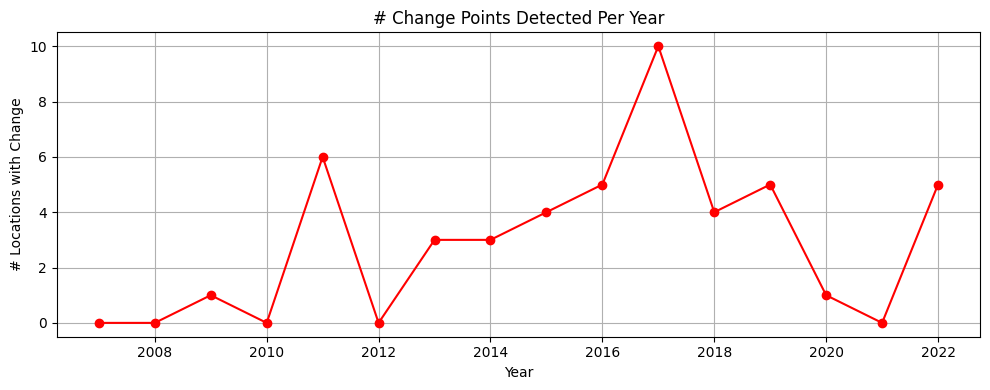


🖼 Generating visual timelines per location...

📈 Generating change score line plots per location...

✅ All visualizations saved to: /content/drive/MyDrive/citypulse-final/changepoint_visualizations


In [ ]:
#  Stage 2: Temporal Change Point Detection Visualization
# This code:
# - Loads the change scores per location
# - Detects change points (based on score threshold)
# - Counts number of changes per year
# - Plots:
#    (1) timeline graph (year vs # change points)
#    (2) image strip per location with red boxes around detected change periods
#    (3) individual change score plots per location

import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

#  Paths
csv_path = "/content/drive/MyDrive/citypulse-final/change_scores_per_location.csv"
image_root = "/content/drive/MyDrive/citypulse-final/images"
output_plot_folder = "/content/drive/MyDrive/citypulse-final/changepoint_visualizations"
os.makedirs(output_plot_folder, exist_ok=True)

#  Load change score data
df = pd.read_csv(csv_path)

# --- CONFIG ---
change_threshold = 0.7  # Change score threshold
min_year = 2007
max_year = 2022

#  Create change point count dictionary
year_change_counts = {y: 0 for y in range(min_year, max_year + 1)}
location_segments = {}  # for image strip visualization

#  Detect change points and tally per year
for loc in df['location'].unique():
    df_loc = df[df['location'] == loc].copy()
    df_loc.sort_values(by=['year_1', 'year_2'], inplace=True)

    # Consider only adjacent years for change point detection
    timeline = sorted(set(df_loc['year_1']).union(df_loc['year_2']))
    year_scores = {y: 0.0 for y in timeline}
    change_years = []

    for i in range(len(timeline) - 1):
        y1, y2 = timeline[i], timeline[i+1]
        score_row = df_loc[(df_loc['year_1'] == y1) & (df_loc['year_2'] == y2)]
        if not score_row.empty:
            score = float(score_row.iloc[0]['score'])
            year_scores[y2] = score  # assign score to second year
            if score > change_threshold:
                year_change_counts[y2] += 1
                change_years.append(y2)

    location_segments[loc] = (timeline, change_years, year_scores)

#  Plot 1: Timeline of # of change points per year
plt.figure(figsize=(10, 4))
years = sorted(year_change_counts.keys())
counts = [year_change_counts[y] for y in years]
plt.plot(years, counts, '-o', color='red')
plt.title("# Change Points Detected Per Year")
plt.xlabel("Year")
plt.ylabel("# Locations with Change")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_plot_folder}/change_point_timeline.png")
plt.show()

#  Plot 2: Image Strips + Red Boxes per Location
print("\n🖼 Generating visual timelines per location...")
for loc, (years, change_years, year_scores) in location_segments.items():
    city, loc_id = loc.split("/")
    folder = os.path.join(image_root, city, loc_id)
    if not os.path.exists(folder): continue

    fig, axs = plt.subplots(1, len(years), figsize=(2*len(years), 3), constrained_layout=True)
    if len(years) == 1:
        axs = [axs]  # fix if only 1 image

    for i, y in enumerate(years):
        img_path = os.path.join(folder, f"{y}.jpg")
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            axs[i].imshow(img)
        else:
            axs[i].text(0.5, 0.5, f"{y}\n(no image)", ha='center')

        axs[i].set_title(str(y), fontsize=8)
        axs[i].axis("off")

        # Draw red rectangle manually using patches
        if y in change_years:
            rect = plt.Rectangle((0, 0), 1, 1, transform=axs[i].transAxes,
                                 linewidth=4, edgecolor='red', facecolor='none', clip_on=False)
            axs[i].add_patch(rect)

    fig.suptitle(f"{loc}", fontsize=12)
    plt.savefig(os.path.join(output_plot_folder, f"{city}_{loc_id}_strip.png"))
    plt.close()

#  Plot 3: Change Score Line Plot per Location
print("\n📈 Generating change score line plots per location...")
for loc, (years, _, year_scores) in location_segments.items():
    city, loc_id = loc.split("/")
    y_vals = [year_scores[y] for y in years]

    plt.figure(figsize=(8, 3))
    plt.plot(years, y_vals, marker='o', color='black')
    plt.title(f"{loc} - Change Score Over Time")
    plt.xlabel("Year")
    plt.ylabel("Change Score")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_plot_folder, f"{city}_{loc_id}_scoreplot.png"))
    plt.close()

print(f"\n✅ All visualizations saved to: {output_plot_folder}")


In [ ]:
import pandas as pd

# Load change score data
df = pd.read_csv("/content/drive/MyDrive/citypulse-final/change_scores_per_location.csv")

# Group by location and find year pair with max score
summary = []
for loc in df['location'].unique():
    df_loc = df[df['location'] == loc]
    max_row = df_loc.loc[df_loc['score'].idxmax()]
    summary.append({
        'location': loc,
        'year_1': int(max_row['year_1']),
        'year_2': int(max_row['year_2']),
        'max_score': round(max_row['score'], 4)
    })

# Create dataframe
summary_df = pd.DataFrame(summary)
summary_df['change_year'] = summary_df['year_2']  # treat year_2 as the time when change is visible

# Save to Drive
output_path = "/content/drive/MyDrive/citypulse-final/location_max_change_summary.csv"
summary_df.to_csv(output_path, index=False)

print(f"✅ Summary saved to: {output_path}")
summary_df.head()


✅ Summary saved to: /content/drive/MyDrive/citypulse-final/location_max_change_summary.csv


,location,year_1,year_2,max_score,change_year
0,seattle/seattle_1673_na,2015,2021,0.1261,2021
1,seattle/seattle_2355_na,2011,2018,0.9872,2018
2,seattle/seattle_1874_na,2007,2021,0.8573,2021
3,seattle/seattle_2785_na,2015,2021,0.4354,2021
4,seattle/seattle_4963_na,2007,2014,0.9945,2014


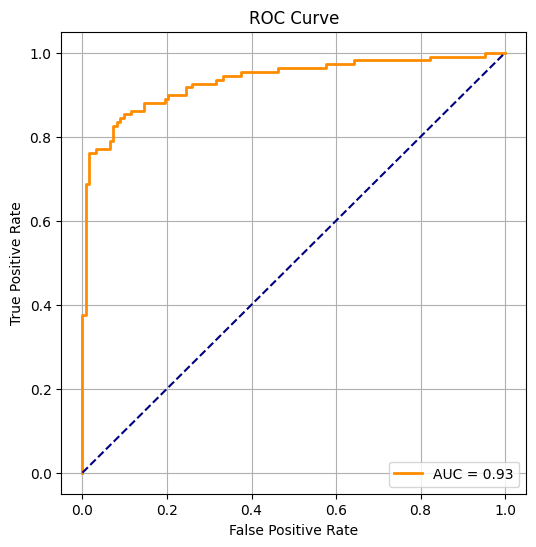

In [ ]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#  Load the predictions
df = pd.read_csv('/content/drive/MyDrive/citypulse-final/test_predictions.csv')

# 🏷 Define true labels and predicted probabilities
test_labels = df['ground_truth'].values
test_probs = df['predicted_score'].values

#  Compute ROC curve
fpr, tpr, _ = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)

#  Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


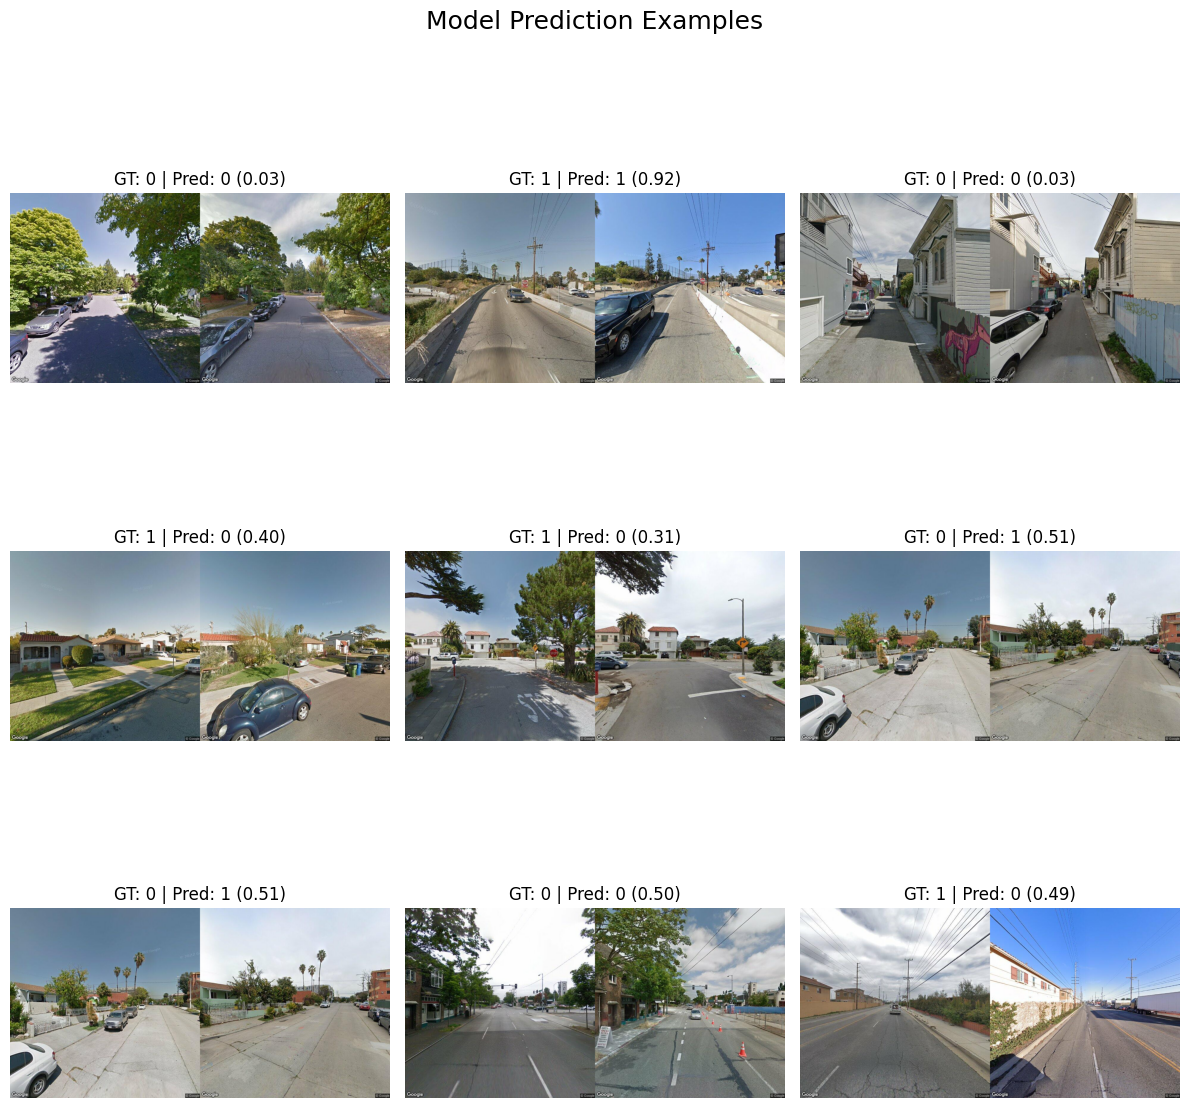

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# 📥 Load your prediction results
df = pd.read_csv('/content/drive/MyDrive/citypulse-final/test_predictions.csv')  # Adjust path if needed

# ✅ Define confidence threshold for categories
confident_threshold = 0.85
uncertain_lower = 0.45
uncertain_upper = 0.55

# 🟢 Correct & Confident
correct_confident = df[(df['ground_truth'] == df['predicted_label']) &
                       ((df['predicted_score'] >= confident_threshold) | (df['predicted_score'] <= 1 - confident_threshold))].head(3)

# 🔴 Incorrect
incorrect = df[(df['ground_truth'] != df['predicted_label'])].head(3)

# 🟡 Uncertain (near 0.5)
uncertain = df[(df['predicted_score'] >= uncertain_lower) &
               (df['predicted_score'] <= uncertain_upper)].head(3)

# 🧩 Combine all
examples = pd.concat([correct_confident, incorrect, uncertain], ignore_index=True)

# 📊 Plot 3×3 grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
categories = ['Correct & Confident', 'Incorrect', 'Uncertain']

for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        if idx < len(examples):
            row = examples.iloc[idx]
            img1 = Image.open(row['image_1'])
            img2 = Image.open(row['image_2'])

            # Show side-by-side
            combined = Image.new('RGB', (img1.width + img2.width, img1.height))
            combined.paste(img1, (0, 0))
            combined.paste(img2, (img1.width, 0))

            axes[i, j].imshow(combined)
            axes[i, j].axis('off')
            axes[i, j].set_title(f"GT: {row['ground_truth']} | Pred: {row['predicted_label']} ({row['predicted_score']:.2f})")
        else:
            axes[i, j].axis('off')

# 🖼 Add labels for rows
for i, label in enumerate(categories):
    axes[i, 0].set_ylabel(label, fontsize=14)

plt.tight_layout()
plt.suptitle("Model Prediction Examples", fontsize=18, y=1.03)
plt.show()


In [ ]:
import os
import torch
import pandas as pd
from PIL import Image
from torch import nn
from torchvision import transforms
from tqdm import tqdm

# ========== 1. Setup ========== #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csv_path = "/content/drive/MyDrive/citypulse-final/pairwise_training_data2.csv"
checkpoint_path = "/content/drive/MyDrive/citypulse-final/citypulse_siamese_checkpoint.pt"  # Colab local path
save_path = "/content/drive/MyDrive/citypulse-final/pairwise_predictions.csv"

# ========== 2. Define Transform (Same as training) ========== #
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# ========== 3. Define DINOv2 Wrapper (Same as training) ========== #
class DinoEncoder(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model.forward_features(x)["x_norm_clstoken"]

# ========== 4. Define Siamese Network (Same as training) ========== #
class SiameseNetwork(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Sequential(
            nn.Linear(768 * 2, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        with torch.no_grad():
            f1 = self.encoder(x1)
            f2 = self.encoder(x2)
        concat = torch.cat((f1, f2), dim=1)
        return self.fc(concat).squeeze()

# ========== 5. Load Pretrained DINOv2 & Model Checkpoint ========== #
encoder = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14', source='github')
dino_encoder = DinoEncoder(encoder)
model = SiameseNetwork(dino_encoder).to(device)

# Load model checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model.eval()

# ========== 6. Run Predictions on Full Dataset ========== #
df = pd.read_csv(csv_path)
results = []

print(f"📂 Running predictions on {len(df)} image pairs...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    img1_path, img2_path = row['image_1'], row['image_2']
    label = int(row['label'])

    try:
        img1 = transform(Image.open(img1_path).convert("RGB")).unsqueeze(0).to(device)
        img2 = transform(Image.open(img2_path).convert("RGB")).unsqueeze(0).to(device)
    except Exception as e:
        print(f"⚠️ Skipped: {img1_path} or {img2_path} — {e}")
        continue

    with torch.no_grad():
        score = model(img1, img2).item()
        pred = 1 if score > 0.5 else 0

    results.append({
        'image_1': img1_path,
        'image_2': img2_path,
        'ground_truth': label,
        'predicted_score': round(score, 4),
        'predicted_label': pred
    })

# ========== 7. Save Predictions ========== #
df_pred = pd.DataFrame(results)
df_pred.to_csv(save_path, index=False)
print(f"\n Saved full predictions to:\n{save_path}")


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


📂 Running predictions on 1160 image pairs...


100%|██████████| 1160/1160 [44:07<00:00,  2.28s/it]


 Saved full predictions to:
/content/drive/MyDrive/citypulse-final/pairwise_predictions.csv


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


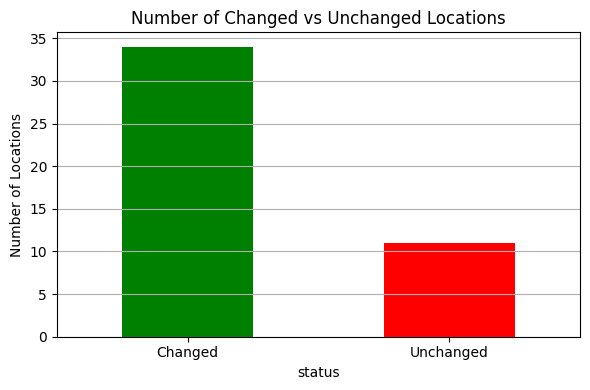

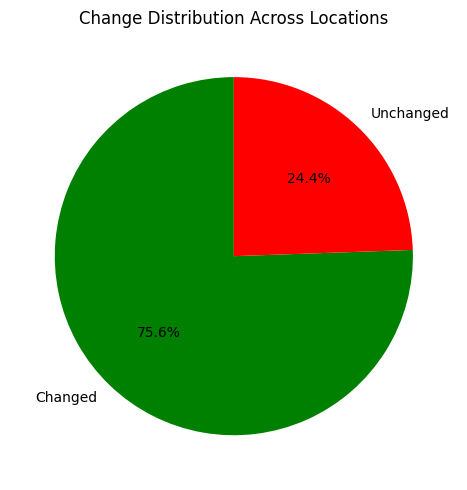

✅ Bar chart saved to: /content/drive/MyDrive/citypulse-final/change_summary_visuals/bar_chart_change_vs_nochange.png
✅ Pie chart saved to: /content/drive/MyDrive/citypulse-final/change_summary_visuals/pie_chart_change_distribution.png
✅ Per-city summary CSV saved to: /content/drive/MyDrive/citypulse-final/change_summary_visuals/city_change_summary.csv

📊 Per-City Change Summary:
status   Changed  Unchanged
city                       
boston         9          0
la             8          1
oakland        4          5
seattle        7          3
sf             6          2


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# === MOUNT DRIVE ===
from google.colab import drive
drive.mount('/content/drive')

# === CONFIG ===
csv_path = "/content/drive/MyDrive/citypulse-final/pairwise_predictions.csv"
output_dir = "/content/drive/MyDrive/citypulse-final/change_summary_visuals"
os.makedirs(output_dir, exist_ok=True)

# === LOAD DATA ===
df = pd.read_csv(csv_path)

# Extract base location identifier (e.g., seattle/loc_001)
df['location'] = df['image_1'].apply(lambda x: '/'.join(x.split('/')[-3:-1]))

# Group by location and determine status
location_status = df.groupby('location')['predicted_label'].max().reset_index()
location_status['status'] = location_status['predicted_label'].apply(lambda x: 'Changed' if x == 1 else 'Unchanged')

# Count changed vs unchanged
status_counts = location_status['status'].value_counts()

# === BAR CHART ===
plt.figure(figsize=(6, 4))
status_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Number of Changed vs Unchanged Locations')
plt.ylabel('Number of Locations')
plt.xticks(rotation=0)
plt.grid(axis='y')
bar_path = os.path.join(output_dir, 'bar_chart_change_vs_nochange.png')
plt.tight_layout()
plt.savefig(bar_path)
plt.show()

# === PIE CHART ===
plt.figure(figsize=(5, 5))
status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
plt.title('Change Distribution Across Locations')
plt.ylabel('')
pie_path = os.path.join(output_dir, 'pie_chart_change_distribution.png')
plt.tight_layout()
plt.savefig(pie_path)
plt.show()

# === PER-CITY SUMMARY TABLE ===
location_status['city'] = location_status['location'].apply(lambda x: x.split('/')[0])
city_summary = location_status.groupby(['city', 'status']).size().unstack(fill_value=0)
city_summary_path = os.path.join(output_dir, 'city_change_summary.csv')
city_summary.to_csv(city_summary_path)

# === LOG OUTPUT PATHS ===
print(f"✅ Bar chart saved to: {bar_path}")
print(f"✅ Pie chart saved to: {pie_path}")
print(f"✅ Per-city summary CSV saved to: {city_summary_path}")

# Optional: show summary
print("\n📊 Per-City Change Summary:")
print(city_summary)
